## Stock price predictions using analysis of news articles


The Efficient Market Hypothesis is a theory whereby share prices reflect all information available to the public. Today, investment companies try to be the fastest at gathering and processing said information. Of course, they use and Machine Learning and Natural Language Processing to extract the most information they can at the fastest possible speed. They use  technical indicators as well as sentiment of available news from every data source available (News, Twitter, Reddit, and probably others) in order to be among the first responders to expected market fluctuations.
I want to demonstrate a basic model of how we can implement Deep Learning methods and Natural Language Processing to combine both news and technical indicators to predict stock price fluctuations.

The textual data is made of 25 daily headlines scraped from the WorldNews subreddit, and the financial data's source is the yahoo finance website. For more info, see project summary. 


This is a more complete  (and visual) tutorial regarding my project.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import pandas as pd
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Preprocessing: News headlines

Let's import the news and take a look at them:
The labels are dropped immediately because they are there for binary classification.


In [12]:
news_data=pd.read_csv('//content//drive//My Drive//Combined_News_DJIA.csv')

nrows=news_data['Date'].count()
news_data.index = range(nrows)
news_data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

In [13]:
news_data.tail()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
1984,2016-06-27,0,Barclays and RBS shares suspended from trading...,Pope says Church should ask forgiveness from g...,Poland 'shocked' by xenophobic abuse of Poles ...,"There will be no second referendum, cabinet ag...","Scotland welcome to join EU, Merkel ally says",Sterling dips below Friday's 31-year low amid ...,No negative news about South African President...,Surge in Hate Crimes in the U.K. Following U.K...,Weapons shipped into Jordan by the CIA and Sau...,Angela Merkel said the U.K. must file exit pap...,In a birth offering hope to a threatened speci...,Sky News Journalist Left Speechless As Leave M...,Giant panda in Macau gives birth to twins,Get out now: EU leader tells Britain it must i...,Sea turtle 'beaten and left for dead' on beach...,German lawyers to probe Erdogan over alleged w...,"Boris Johnson says the UK will continue to ""in...",Richard Branson is calling on the UK governmen...,Turkey 'sorry for downing Russian jet',Edward Snowden lawyer vows new push for pardon...,Brexit opinion poll reveals majority don't wan...,"Conservative MP Leave Campaigner: ""The leave c...","Economists predict UK recession, further weake...","New EU 'superstate plan by France, Germany: Cr...",Pakistani clerics declare transgender marriage...
1985,2016-06-28,1,"2,500 Scientists To Australia: If You Want To ...","The personal details of 112,000 French police ...",S&amp;P cuts United Kingdom sovereign credit r...,Huge helium deposit found in Africa,CEO of the South African state broadcaster qui...,"Brexit cost investors $2 trillion, the worst o...",Hong Kong democracy activists call for return ...,Brexit: Iceland president says UK can join 'tr...,UK's Osborne: 'Absolutely' going to have to cu...,'Do not let Scotland down now' : Scottish MEP ...,British pound could hit history-making dollar ...,"Merkel vows to strengthen EU, tells UK no 'che...","""Ryanair will not deploy new aircraft on route...","People, ever more greedy and stupid, destroy t...",Siemens freezes new UK wind power investment f...,"US, Canada and Mexico pledge 50% of power from...",There is increasing evidence that Australia is...,"Richard Branson, the founder of Virgin Group, ...","37,000-yr-old skull from Borneo reveals surpri...",Palestinians stone Western Wall worshipers; po...,Jean-Claude Juncker asks Farage: Why are you h...,"""Romanians for Remainians"" offering a new home...",Brexit: Gibraltar in talks with Scotland to st...,8 Suicide Bombers Strike Lebanon,Mexico's security forces routinely use 'sexual...
1986,2016-06-29,1,Explosion At Airport In Istanbul,Yemeni former president: Terrorism is the offs...,UK must accept freedom of movement to access E...,Devastated: scientists too late to captive bre...,British Labor Party leader Jeremy Corbyn loses...,A Muslim Shop in the UK Was Just Firebombed Wh...,Mexican Authorities Sexually Torture Women in ...,UK shares and pound continue to recover,Iceland historian Johannesson wins presidentia...,99-Million-Yr-Old Bird Wings Found Encased in ...,A chatbot programmed by a British teenager has...,The Philippine president-elect said Monday he ...,Former Belgian Prime Minister ridicules Nigel ...,Brexiteer Nigel Farage To EU: 'You're Not Laug...,Islamic State bombings in southern Yemen kill ...,"Escape Tunnel, Dug by Hand, Is Found at Holoca...",The land under Beijing is sinking by as much a...,Car bomb and Anti-Islamic attack on Mosque in ...,Emaciated lions in Taiz Zoo are trapped in blo...,Rupert Murdoch describes Brexit as 'wonderful'...,More than 40 killed in Yemen suicide attacks,Google Found Disastrous Symantec and Norton Vu...,Extremist violence on the rise in Germany: Dom...,BBC News: Labour MPs pass Corbyn no-confidence...,Tiny New Zealand town with 'too many jobs' lau...
1987,2016-06-30,1,Jamaica proposes marijuana dispensers for tour...,Stephen Hawking says p

Number of diffrent dates for news:

In [14]:
print(nrows)

1989


We have 25 news article for every day

In [15]:
columns=news_data.columns
print(columns)

new_columns = ['Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25']

tokenized_news_df=news_data[new_columns]

for i in new_columns:
    tokenized_news_df[i]=tokenized_news_df[i].str.strip('b')
    tokenized_news_df[i]=tokenized_news_df[i].str.strip('"')
    tokenized_news_df[i]=tokenized_news_df[i].str.strip("'")

tokenized_news_df.head()

Index(['Date', 'Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25'],
      dtype='object')


,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,Georgia 'downs two Russian warplanes' as count...,BREAKING: Musharraf to be impeached.,Russia Today: Columns of troops roll into Sout...,Russian tanks are moving towards the capital o...,"Afghan children raped with 'impunity,' U.N. of...",150 Russian tanks have entered South Ossetia w...,"Breaking: Georgia invades South Ossetia, Russi...",The 'enemy combatent' trials are nothing but a...,Georgian troops retreat from S. Osettain capit...,Did the U.S. Prep Georgia for War with Russia?,Rice Gives Green Light for Israel to Attack Ir...,Announcing:Class Action Lawsuit on Behalf of A...,So---Russia and Georgia are at war and the NYT...,China tells Bush to stay out of other countrie...,Did World War III start today?,Georgia Invades South Ossetia - if Russia gets...,Al-Qaeda Faces Islamist Backlash,"Condoleezza Rice: ""The US would not act to pre...",This is a busy day: The European Union has ap...,"Georgia will withdraw 1,000 soldiers from Iraq...",Why the Pentagon Thinks Attacking Iran is a Ba...,Caucasus in crisis: Georgia invades South Ossetia,Indian shoe manufactory - And again in a seri...,Visitors Suffering from Mental Illnesses Banne...,No Help for Mexico's Kidnapping Surge
1,Why wont America and Nato help us? If they won...,Bush puts foot down on Georgian conflict,Jewish Georgian minister: Thanks to Israeli tr...,Georgian army flees in disarray as Russians ad...,Olympic opening ceremony fireworks 'faked,What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in S.Ossetia blames...,Welcome To World War IV! Now In High Definition!,"Georgia's move, a mistake of monumental propor...",Russia presses deeper into Georgia; U.S. says ...,Abhinav Bindra wins first ever Individual Olym...,U.S. ship heads for Arctic to define territory,Drivers in a Jerusalem taxi station threaten t...,The French Team is Stunned by Phelps and the 4...,Israel and the US behind the Georgian aggression?,"""Do not believe TV, neither Russian nor Georgi...",Riots are still going on in Montreal (Canada) ...,China to overtake US as largest manufacturer,War in South Ossetia [PICS],Israeli Physicians Group Condemns State Torture,Russia has just beaten the United States over...,Perhaps *the* question about the Georgia - Rus...,Russia is so much better at war,So this is what it's come to: trading sex for ...
2,Remember that adorable 9-year-old who sang at ...,Russia 'ends Georgia operation,"""If we had no sexual harassment we would have ...",Al-Qa'eda is losing support in Iraq because of...,Ceasefire in Georgia: Putin Outmaneuvers the West,Why Microsoft and Intel tried to kill the XO $...,Stratfor: The Russo-Georgian War and the Balan...,I'm Trying to Get a Sense of This Whole Georgi...,The US military was surprised by the timing an...,U.S. Beats War Drum as Iran Dumps the Dollar,"Gorbachev: ""Georgian military attacked the Sou...",CNN use footage of Tskhinvali ruins to cover G...,Beginning a war as the Olympics were opening v...,55 pyramids as large as the Luxor stacked into...,The 11 Top Party Cities in the World,U.S. troops still in Georgia (did you know the...,Why Russias response to Georgia was right,"Gorbachev accuses U.S. of making a ""serious bl...","Russia, Georgia, and NATO: Cold War Two",Remember that adorable 62-year-old who led you...,War in Georgia: The Israeli connection,All signs point to the US encouraging Georgia ...,Christopher King argues that the US and NATO a...,America: The New Mexico?,BBC NEWS | Asia-Pacific | Extinction 'by man n...
3,U.S. refuses Israel weapons to attack Iran: r...,When the president ordered to attack Tskhinval...,Israel clears troops who killed Reuters camer...,"Britain\'s policy of being tough on drugs is ""...",Body of 14 year old found in trunk; Latest (ra...,China has moved 10 *million* quake survivors i...,

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def remove_stopwords(text):
    stopwords_list=stopwords.words('english')
    not_stopwords=['not','no'] #We could whitetelist other words too
    words=text.split()
    essential_words = [word for word in words if (word not in stopwords_list or word in not_stopwords) and len(word) > 1]
    return " ".join(essential_words)


In [0]:
#We run the next line to remove stopwords:
for i in new_columns:
    tokenized_news_df[i] = tokenized_news_df[i].astype(str).apply(remove_stopwords)

In [18]:
tokenized_news_df.head()

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,Georgia 'downs two Russian warplanes' countrie...,BREAKING: Musharraf impeached.,Russia Today: Columns troops roll South Osseti...,Russian tanks moving towards capital South Oss...,"Afghan children raped 'impunity,' U.N. officia...",150 Russian tanks entered South Ossetia whilst...,"Breaking: Georgia invades South Ossetia, Russi...",The 'enemy combatent' trials nothing sham: Sal...,"Georgian troops retreat S. Osettain capital, p...",Did U.S. Prep Georgia War Russia?,Rice Gives Green Light Israel Attack Iran: Say...,Announcing:Class Action Lawsuit Behalf America...,So---Russia Georgia war NYT's top story openin...,China tells Bush stay countries' affairs,Did World War III start today?,Georgia Invades South Ossetia Russia gets invo...,Al-Qaeda Faces Islamist Backlash,"Condoleezza Rice: ""The US would not act preven...",This busy day: The European Union approved new...,"Georgia withdraw 1,000 soldiers Iraq help figh...",Why Pentagon Thinks Attacking Iran Bad Idea US...,Caucasus crisis: Georgia invades South Ossetia,"Indian shoe manufactory And series ""you not li...",Visitors Suffering Mental Illnesses Banned Oly...,No Help Mexico's Kidnapping Surge
1,Why wont America Nato help us? If wont help us...,Bush puts foot Georgian conflict,Jewish Georgian minister: Thanks Israeli train...,Georgian army flees disarray Russians advance ...,Olympic opening ceremony fireworks 'faked,What Mossad fraudulent New Zealand Passports I...,Russia angered Israeli military sale Georgia,An American citizen living S.Ossetia blames U....,Welcome To World War IV! Now In High Definition!,"Georgia's move, mistake monumental proportions",Russia presses deeper Georgia; U.S. says regim...,Abhinav Bindra wins first ever Individual Olym...,U.S. ship heads Arctic define territory,Drivers Jerusalem taxi station threaten quit r...,The French Team Stunned Phelps 4x100m Relay Team,Israel US behind Georgian aggression?,"""Do not believe TV, neither Russian Georgian. ...",Riots still going Montreal (Canada) police mur...,China overtake US largest manufacturer,War South Ossetia [PICS],Israeli Physicians Group Condemns State Torture,Russia beaten United States head Peak Oil,Perhaps *the* question Georgia Russia conflict,Russia much better war,So come to: trading sex food.
2,Remember adorable 9-year-old sang opening cere...,Russia 'ends Georgia operation,"""If no sexual harassment would no children...""",Al-Qa'eda losing support Iraq brutal crackdown...,Ceasefire Georgia: Putin Outmaneuvers West,Why Microsoft Intel tried kill XO $100 laptop,Stratfor: The Russo-Georgian War Balance Power,I'm Trying Get Sense This Whole Georgia-Russia...,The US military surprised timing swiftness Rus...,U.S. Beats War Drum Iran Dumps Dollar,"Gorbachev: ""Georgian military attacked South O...",CNN use footage Tskhinvali ruins cover Georgia...,Beginning war Olympics opening violates ancien...,55 pyramids large Luxor stacked mega-city pyra...,The 11 Top Party Cities World,U.S. troops still Georgia (did know Georgia fi...,Why Russias response Georgia right,"Gorbachev accuses U.S. making ""serious blunder...","Russia, Georgia, NATO: Cold War Two",Remember adorable 62-year-old led country war ...,War Georgia: The Israeli connection,All signs point US encouraging Georgia invade ...,Christopher King argues US NATO behind Georgia...,America: The New Mexico?,BBC NEWS Asia-Pacific Extinction 'by man not c...
3,U.S. refuses Israel weapons attack Iran: report,When president ordered attack Tskhinvali [the ...,Israel clears troops killed Reuters cameraman,"Britain\'s policy tough drugs ""pointless"", say...",Body 14 year old found trunk; Latest (ransom p...,China moved 10 *million* quake survivors prefa...,Bush announces Operation Get All Up In Russia'...,Russian forces sink Georgian ships,The commander Navy air reconnaissance squadron...,92% CNN readers: Russia'

In [0]:
NB_WORDS = 40000  # Parameter indicating the number of words we'll put in the dictionary
MAX_LEN = 27  # Maximum number of words in a sequence (95% of words are less than 27 words (done in another analysis))
GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings
NUM_DAYS=1989

In [0]:
tokenized_news_seq=[]
tokenizer = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
for j, i in enumerate (new_columns):
    tokenizer.fit_on_texts(tokenized_news_df[i])
    tokenized_news_seq.append(tokenizer.texts_to_sequences(tokenized_news_df[i]))

In [0]:
def pad_nested_sequences(sequences, dtype='int32'):
    """Pads nested sequences to the same length.
    This function transforms a list of list sequences
    into a 3D Numpy array of shape `(num_samples, max_sent_len, max_word_len)`.
    Args:
        sequences: List of lists of lists.
        dtype: Type of the output sequences.
    # Returns
        x: Numpy array.
    """
    max_sent_len = 25
    max_word_len = MAX_LEN
    for sent in sequences:
        max_sent_len = max(len(sent), max_sent_len)
        for word in sent:
            max_word_len = max_word_len

    x = np.zeros((len(sequences), max_sent_len, max_word_len)).astype(dtype)
    for i, sent in enumerate(sequences):
        for j, word in enumerate(sent):
            if j<max_word_len:
                x[i, j, :len(word)] = word

    return x

In [22]:
tokenized_news_seq_padded=pad_nested_sequences(tokenized_news_seq)
tokenized_news_seq_padded=np.transpose(tokenized_news_seq_padded, (1,0,2))
tokenized_news_seq_padded.shape

(1989, 25, 27)

In [23]:
tokenized_news_seq_padded[0][:5]

array([[  915,  3691,    53,    48,  3692,   361,   579,  2432,    20,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [  627,  8696,  8697,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [   39,   181, 12114,   421, 12115,    64,  2239,   733,   582,
          768,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [   40,  1759,  1456,  1327,   474,    60,  2303,   934,  1826,
          805,  2096,  2404,   181,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [  329,    46,   354, 16912,   339,    14,   249,   165,     4,
         2031,    87,    11,    22,   354,   873,     0,     0,     0,
  

In [24]:
unique, counts = np.unique(tokenized_news_seq_padded, return_counts=True)
len(unique)

3095

In [0]:
from sklearn.model_selection import train_test_split

texts_train , texts_test, _, _ = train_test_split(tokenized_news_seq_padded,tokenized_news_seq_padded  ,test_size=0.1,shuffle=False)

In [26]:
texts_test.shape

(199, 25, 27)

In [27]:
texts_train.shape

(1790, 25, 27)

In [29]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('/content/drive/My Drive/glove.6B/glove.6B.100d.txt', encoding='utf-8') #Thanks to pytorch assignment
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((NB_WORDS, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
dj=pd.read_csv('/content/drive/My Drive/DowJones.csv')

In [32]:
nrows_dj=dj['Date'].count()
dj.index = range(nrows_dj)
dj.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-08-07,11655.419922,11655.580078,11416.700195,11431.429688,11431.429688,229610000
1,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320313,11734.320313,212830000
2,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,11782.349609,183190000
3,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,11642.469727,173590000
4,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,11532.959961,182550000


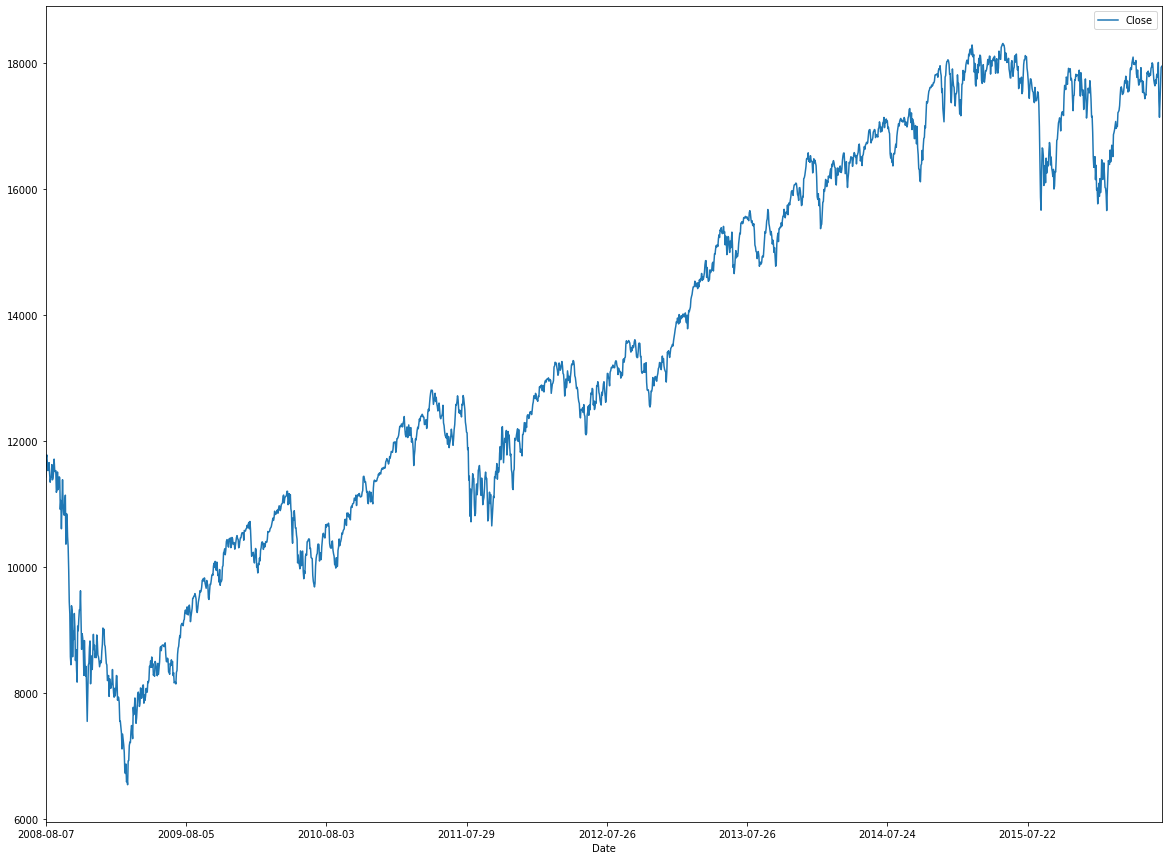

In [34]:
dj.plot(x='Date',y='Close',figsize=(20,15));

In [35]:
dj_long=pd.read_csv('/content/drive/My Drive/^DJI.csv')
nrows_dj_long=dj_long['Date'].count()
dj_long.index = range(nrows_dj_long)
dj_long.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-05-01,12818.339844,13029.049805,12793.099609,13010.000000,13010.000000,245480000
1,2008-05-02,13012.530273,13132.459961,12981.830078,13058.200195,13058.200195,205410000
2,2008-05-05,13056.570313,13058.450195,12939.740234,12969.540039,12969.540039,197810000
3,2008-05-06,12968.889648,13046.150391,12863.200195,13020.830078,13020.830078,199370000
4,2008-05-07,13010.820313,13036.709961,12796.190430,12814.349609,12814.349609,235000000


In [36]:
dj_long.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2053,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,17140.240234,138740000
2054,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,17409.720703,112190000
2055,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,17694.679688,106380000
2056,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,17929.990234,133030000
2057,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,17949.369141,82160000


In [37]:
dj_long.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [38]:
NB_DATES_LONG=len(dj_long)
print(NB_DATES_LONG)

2058


In [40]:
!pip install ta

  Created wheel for ta: filename=ta-0.5.11-cp36-none-any.whl size=23031 sha256=feb7e46d5df1c033f09f3a83cec092e4293a936df614f7f4c4ec68e8e0f64510
  Stored in directory: /root/.cache/pip/wheels/97/32/1d/cbc724a8ecaec6e426baf57ab8c4c2cdc687aadd7427280b1f
Successfully built ta


In [0]:
from ta import *

In [0]:
dj_ta=add_all_ta_features(dj_long, "Open", "High", "Low", "Close", "Volume","Adj Close")

In [43]:
dj_ta.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_nvi', 'volatility_atr',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch',
       'volatility_dchi', 'volatility_dcli', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'trend_visual_ichimoku_a',
       'trend_visual_ichimoku_b', 'trend_aroon_

In [44]:
dj_ta.head()

,Date,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
0,2008-05-01,12818.339844,13029.049805,12793.099609,13010.000000,13010.000000,245480000,2.058416e+08,245480000,0.838527,0.000000e+00,0.000000,0.000000,-7.421202e+06,1000.000000,0.0,13010.000000,13010.000000,13010.000000,0.000000,0.0,0.0,12944.049805,12944.049805,12708.099609,0.0,0.0,13010.000000,13010.000000,1.0,1.0,0.000000,0.000000,0.000000,13010.000000,13010.000000,0.0,0.0,0.0,1.0,1.0,0.0,-2.664063,1.000000,0.000000,404.299919,-30.139472,-30.139472,0.000000,12911.074707,12911.074707,13348.131316,13245.220996,4.0,4.0,0.0,13010.000000,-1.000000,-1.000000,0.0,0.0,100.000000,50.0,0.000000,50.0,91.926345,91.926345,-8.073655,0.0,13010.000000,0.0,-3.013947,0.000000,0.000000
1,2008-05-02,13012.530273,13132.459961,12981.830078,13058.200195,13058.200195,205410000,2.087194e+08,450890000,0.462905,9.900802e+09,10711.530150,10711.530150,-6.637623e+06,1003.704857,0.0,13034.100097,13082.300292,12985.899902,96.400390,0.0,0.0,13000.773275,13000.773275,12807.483235,0.0,0.0,13010.000000,13058.200195,1.0,0.0,3.845030,0.769006,3.076024,13017.415415,13013.570385,0.0,0.0,0.0,1.0,1.0,0.0,0.000724,1.941294,66.666667,380.199822,-28.342875,-29.241173,0.898299,12962.779785,12962.779785,13348.131316,13245.220996,8.0,4.0,4.0,13058.200195,-1.000000,-1.000000,0.0,0.0,100.000000,50.0,100.000000,50.0,78.117725,85.022035,-21.882275,0.0,13058.200195,0.0,0.370486,0.369801,0.370486
2,2008-05-05,13056.570313,13058.450195,12939.740234,12969.540039,12969.540039,197810000,1.102220e+08,253080000,0.169912,5.980992e+09,-3483.691465,3613.919342,-5.820390e+05,996.890088,0.0,13012.580078,13085.062690,12940.097466,144.965225,0.0,0.0,12996.930013,12996.930013,12828.500000,0.0,0.0,12969.540039,13058.200195,0.0,1.0,-0.258906,0.563424,-0.822329,13010.049972,13010.308878,0.0,0.0,0.0,1.0,1.0,0.0,0.000568,2.821945,-12.690999,401.719841,-29.947134,-29.476494,-0.470641,12962.779785,12962.779785,13348.131316,13245.220996,8.0,12.0,-4.0,13029.049805,-1.000000,13029.049805,0.0,1.0,33.546822,50.0,95.994280,50.0,51.992058,74.012042,-48.007942,0.0,12969.540039,0.0,-0.678962,-0.681277,-0.310991
3,2008-05-06,12968.889648,13046.150391,12863.200195,13020.830078,13020.830078,199370000,2.544064e+08,452450000,0.299983,6.587379e+09,-4076.156566,1050.560706,-5.546145e+05,996.890088,0.0,13014.642578,13077.819660,12951.465496,126.354164,0.0,0.0,12991.879232,12991.879232,12819.819173,0.0,0.0,12969.540039,13058.200195,0.0,0.0,0.620224,0.574784,0.045440,13011.708450,13011.088226,0.0,0.0,0.0,1.0,1.0,0.0,0.000600,3.712271,-30.789227,399.657341,-29.793380,-29.555715,-0.237665,12962.779785,12962.779785,13348.131316,13245.220996,8.0,12.0,-4.0,12939.740234,12939.740234,13029.049805,1.0,0.0,53.003557,50.0,92.924335,50.0,67.105797,65.738527,-32.894203,0.0,13020.830078,0.0,0.395465,0.394685,0.083244
4,2008-05-07,13010.820313,13036.709961,12796.190430,12814.349609,12814.349609,235000000,5.489133e+07,217450000,0.050681,-1.285520e+09,-3912.290435,-190.152079,-2.938121e+06,996.890088,0.0,12974.583984,1

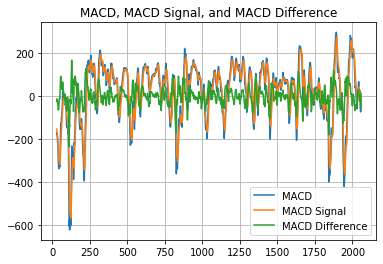

In [45]:
plt.plot(dj_ta.trend_macd[30:], label = 'MACD')
plt.plot(dj_ta.trend_macd_signal[30:], label='MACD Signal')
plt.plot(dj_ta.trend_macd_diff[30:], label='MACD Difference')
plt.title('MACD, MACD Signal, and MACD Difference')
plt.rcParams["figure.figsize"] = [25,10]
plt.legend()
plt.grid()
plt.show()

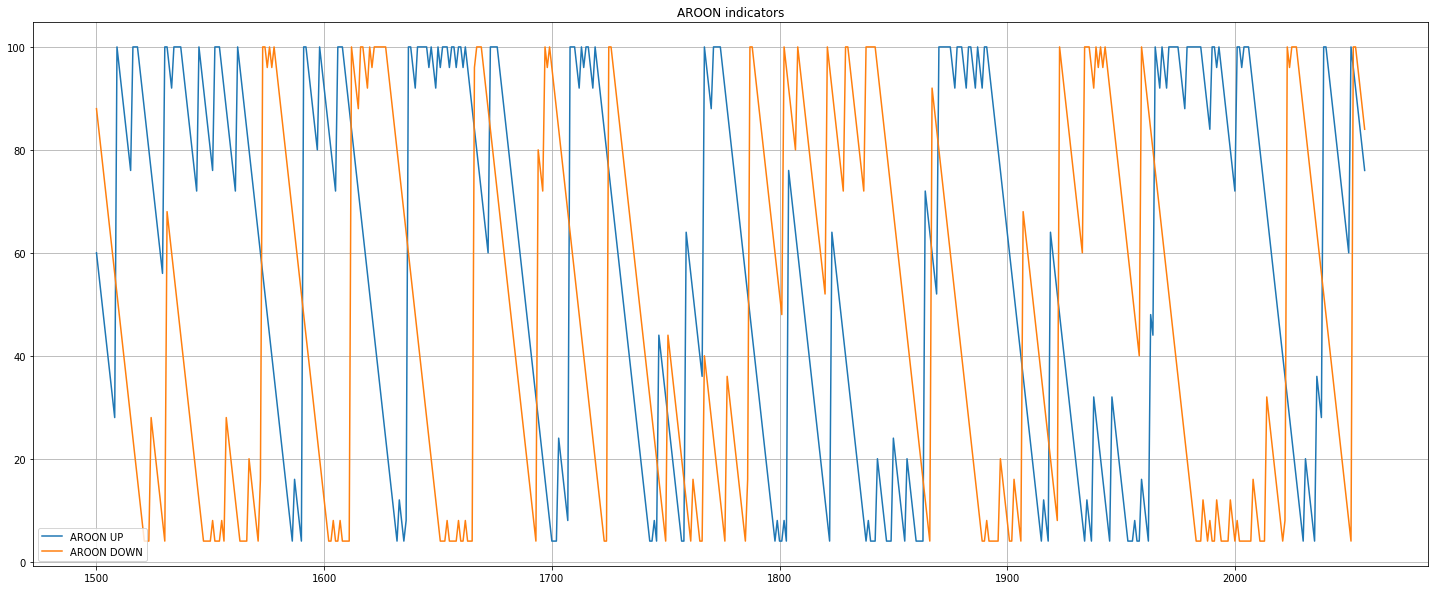

In [46]:
plt.plot(dj_ta.trend_aroon_up[1500:], label='AROON UP')
plt.plot(dj_ta.trend_aroon_down[1500:], label='AROON DOWN')
plt.title('AROON indicators')
plt.rcParams["figure.figsize"] = [25,18]
plt.legend()
plt.grid()
plt.show()

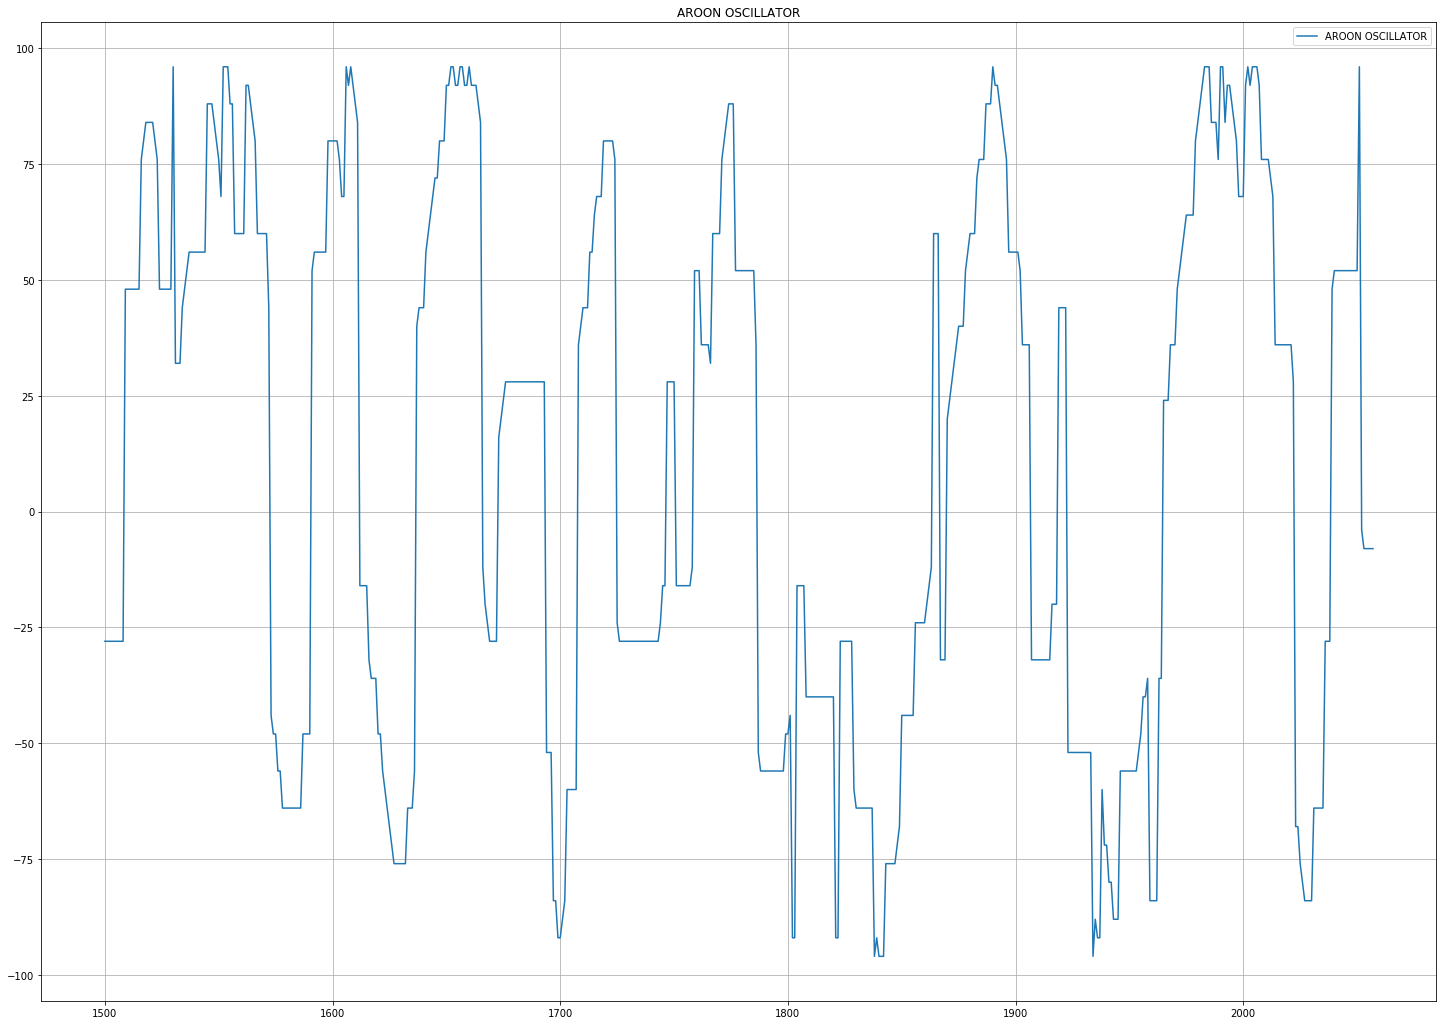

In [47]:
plt.plot(dj_ta.trend_aroon_ind[1500:], label='AROON OSCILLATOR')
plt.title('AROON OSCILLATOR')
plt.rcParams["figure.figsize"] = [25,18]
plt.legend()
plt.grid()
plt.show()

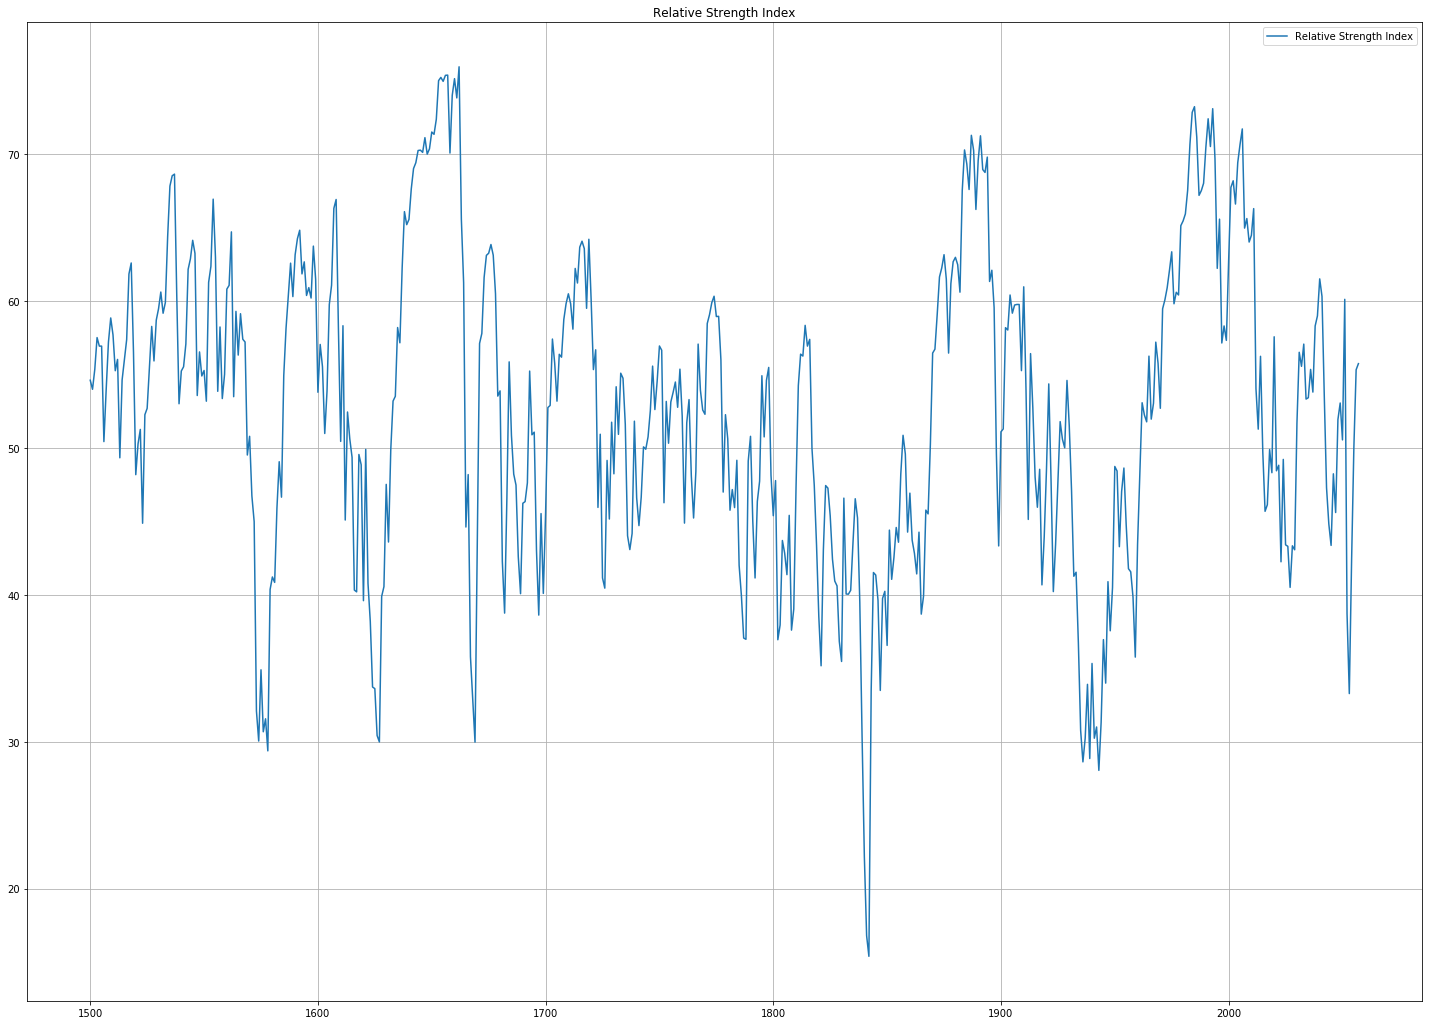

In [48]:
plt.plot(dj_ta.momentum_rsi[1500:], label='Relative Strength Index')
plt.title('Relative Strength Index')
plt.rcParams["figure.figsize"] = [25,18]
plt.legend()
plt.grid()
plt.show()

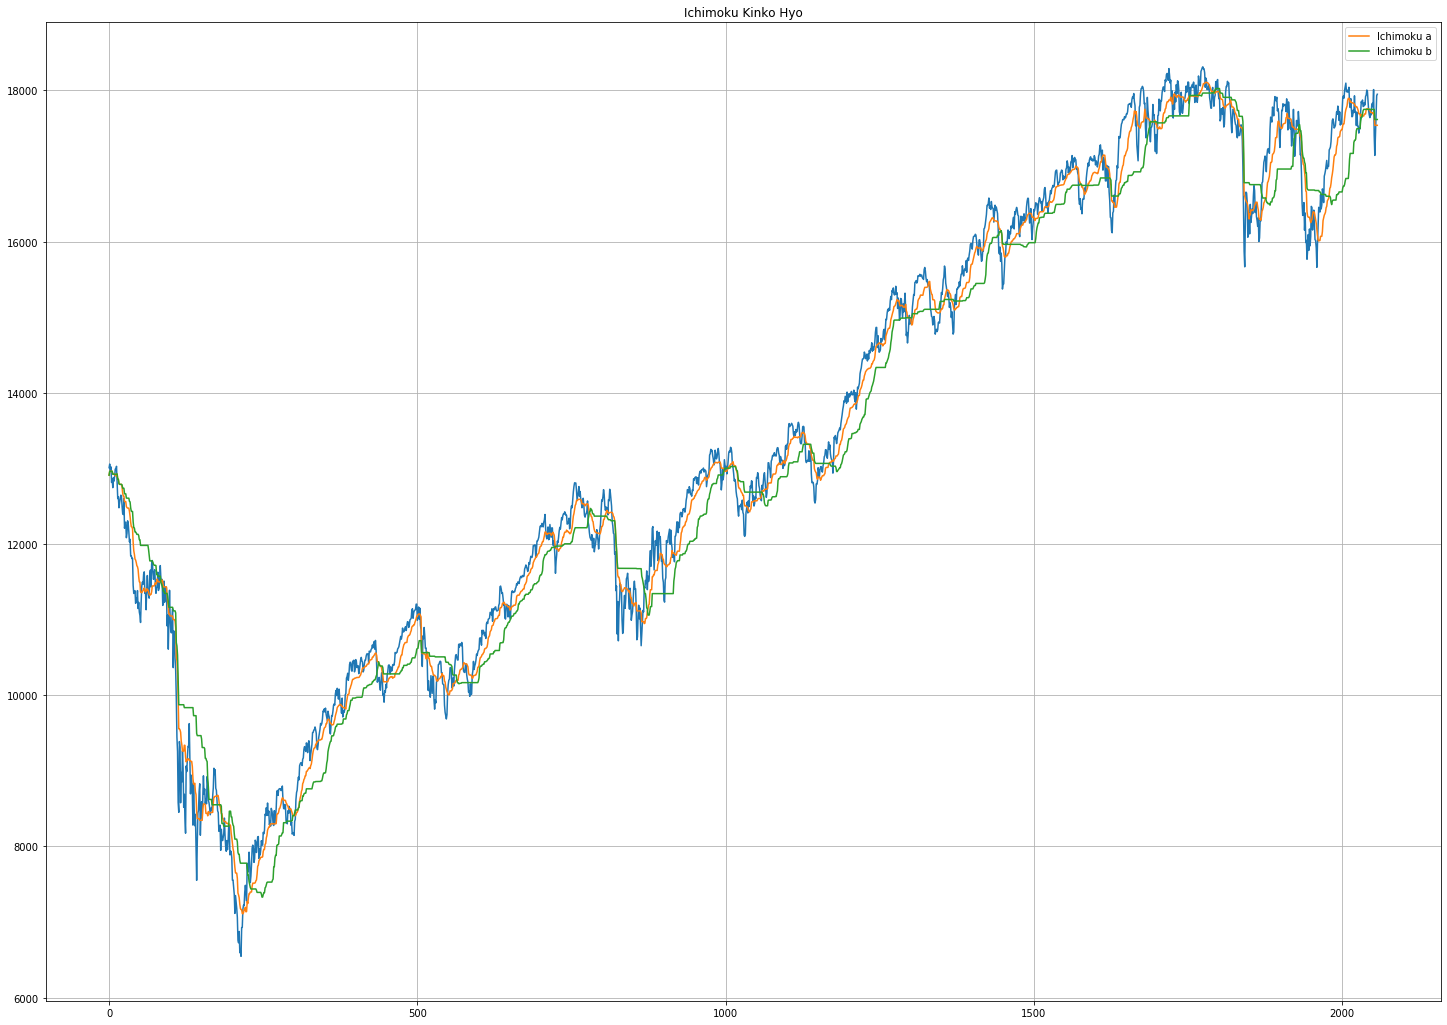

In [49]:
plt.plot(dj_ta.Close)
plt.plot(dj_ta.trend_ichimoku_a[:], label='Ichimoku a')
plt.plot(dj_ta.trend_ichimoku_b[:], label='Ichimoku b')
plt.title('Ichimoku Kinko Hyo')
plt.rcParams["figure.figsize"] = [25,18]
plt.legend()
plt.grid()
plt.show()

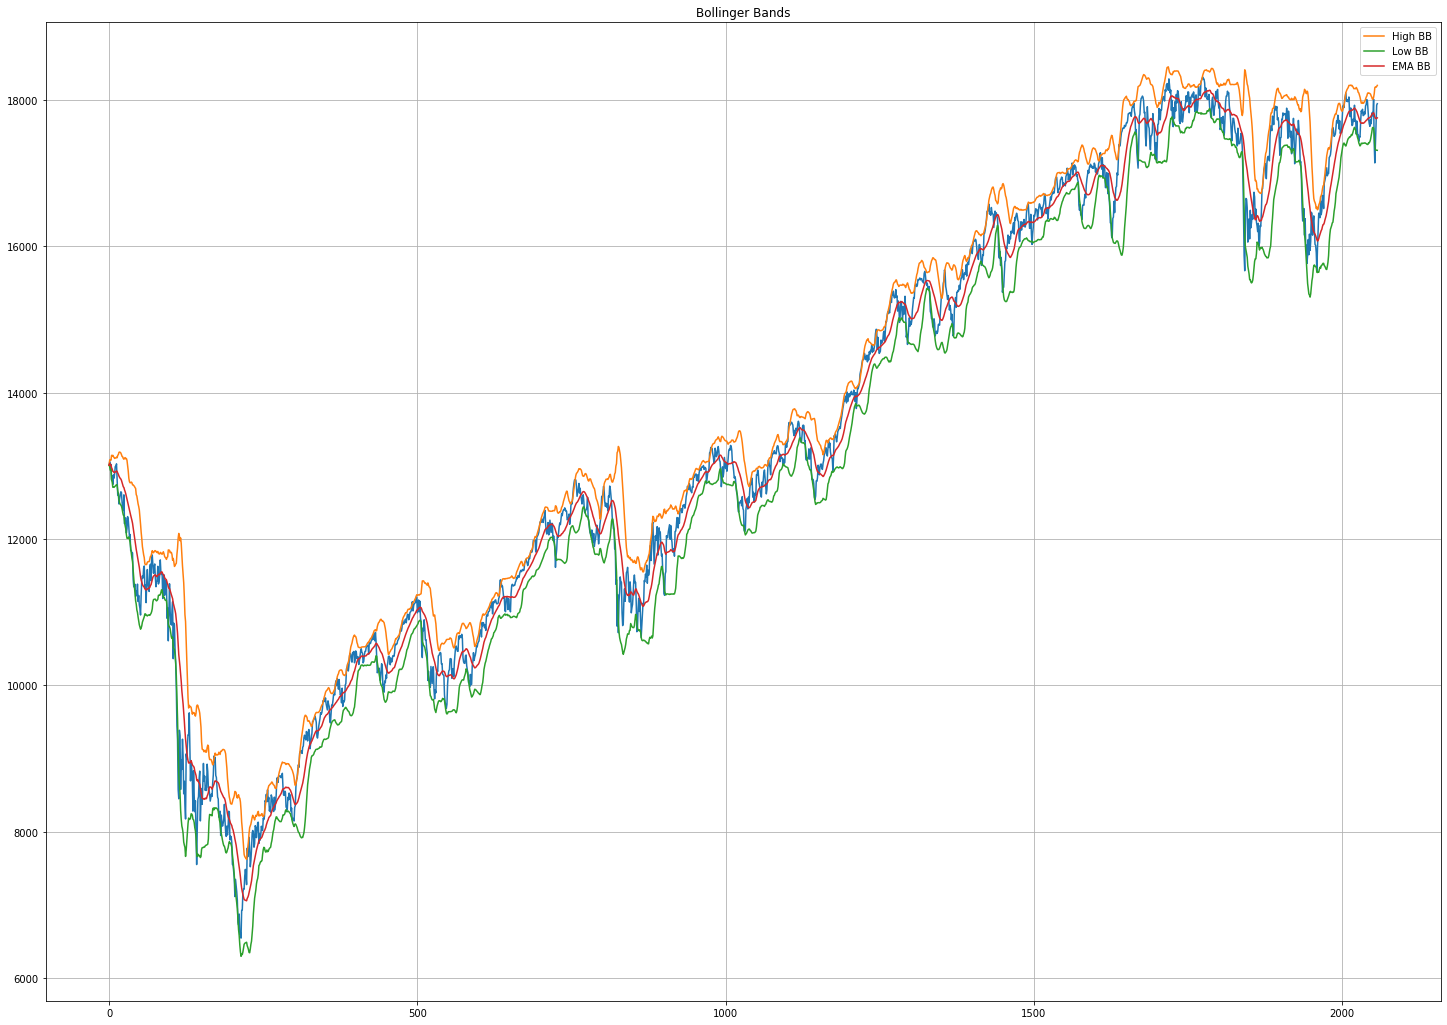

In [50]:
plt.plot(dj_ta.Close)
plt.plot(dj_ta.volatility_bbh, label='High BB')
plt.plot(dj_ta.volatility_bbl, label='Low BB')
plt.plot(dj_ta.volatility_bbm, label='EMA BB')
plt.title('Bollinger Bands')
plt.rcParams["figure.figsize"] = [25,18]
plt.legend()
plt.grid()
plt.show()

In [0]:
dj_ta=dj_ta[['Date', 'Open', 'High', 'Low', 'Close', 'Volume',
       'volume_adi','trend_macd',
       'trend_macd_signal', 'trend_macd_diff','trend_ichimoku_a',
       'trend_ichimoku_b','trend_aroon_ind', 'momentum_rsi']]

In [0]:
dj_ta["Labels"]=dj_ta.Close

In [0]:
dj_ta.Labels=dj_ta.Labels.shift(-1)

In [0]:
dj_rightdates=dj_ta[dj_ta.Date.isin(dj.Date)]

In [55]:
dj_rightdates.head()

,Date,Open,High,Low,Close,Volume,volume_adi,trend_macd,trend_macd_signal,trend_macd_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_ind,momentum_rsi,Labels
68,2008-08-07,11655.419922,11655.580078,11416.700195,11431.429688,229610000,-5.079223e+08,-40.371971,-87.704612,47.332641,11334.117432,11777.185058,64.0,48.341724,11734.320313
69,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320313,212830000,-3.244367e+08,-14.247608,-73.013211,58.765603,11368.922363,11777.185058,72.0,55.659190,11782.349609
70,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,-3.033442e+08,10.213961,-56.367777,66.581738,11445.865235,11777.185058,76.0,56.706437,11642.469727
71,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,-3.983129e+08,18.104101,-41.473401,59.577502,11445.865235,11758.705078,76.0,52.795539,11532.959961
72,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,-4.197610e+08,15.343698,-30.109981,45.453679,11445.865235,11732.895019,76.0,49.894338,11615.929688


In [0]:
nrows_dj_rightdates=dj_rightdates['Date'].count()
dj_rightdates.index = range(nrows_dj_rightdates) #Resetting my index

In [57]:
dj_rightdates.tail()

,Date,Open,High,Low,Close,Volume,volume_adi,trend_macd,trend_macd_signal,trend_macd_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_ind,momentum_rsi,Labels
1985,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,2.666493e+10,-57.285464,-1.439935,-55.845529,17538.307617,17615.355468,-8.0,33.280568,17409.720703
1986,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,2.677712e+10,-72.797826,-15.711513,-57.086313,17538.307617,17615.355468,-8.0,42.316073,17694.679688
1987,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,2.687509e+10,-61.390010,-24.847213,-36.542798,17538.307617,17615.355468,-8.0,50.023442,17929.990234
1988,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,2.700736e+10,-32.981450,-26.474060,-6.507390,17538.307617,17615.355468,-8.0,55.331072,17949.369141
1989,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,2.698761e+10,-8.802278,-22.939704,14.137426,17538.307617,17615.355468,-8.0,55.747884,NaN


In [0]:
dj_rightdates.drop(dj_rightdates.tail(1).index, inplace=True)

In [59]:
dj_rightdates.shape

(1989, 15)

In [0]:
dj_label=dj_rightdates.Labels

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler_features_financial=MinMaxScaler(feature_range = (0,1))
dj_scaled_features=scaler_features_financial.fit_transform(dj_rightdates[[ 'Open', 'High', 'Low', 'Close', 'Volume',
       'volume_adi','trend_macd',
       'trend_macd_signal', 'trend_macd_diff','trend_ichimoku_a',
       'trend_ichimoku_b','trend_aroon_ind', 'momentum_rsi']])
scaler_label=MinMaxScaler(feature_range=(0,1))
dj_scaled_label=scaler_label.fit_transform(np.asarray(dj_label).reshape(-1,1))

In [63]:
NUM_FINANCIAL_FEATURES=dj_scaled_features.shape[1] #Saving this constant for the input shape in the model
print(f'shape of features vector:\n {dj_scaled_features.shape}')
print(f'This is what the scaled features look like:\n {dj_scaled_label[:5]}')

shape of features vector:
 (1988, 13)
This is what the scaled features look like:
 [[0.4408942 ]
 [0.44497647]
 [0.43308732]
 [0.42377949]
 [0.43083154]]


In [64]:
NUM_FINANCIAL_FEATURES

13

In [65]:
dj_scaled_features[:,3]

array([0.41514988, 0.4408942 , 0.44497647, ..., 0.90037259, 0.9232772 ,
       0.9474974 ])

In [0]:
dj_rightdates=dj_rightdates.drop('Date', axis='columns')
from sklearn.model_selection import train_test_split

dj_rightdates_train , dj_rightdates_test, dj_label_train, dj_label_test = train_test_split(dj_scaled_features, dj_scaled_label, test_size=0.1,shuffle=False)

In [67]:
print(f"Training set length: {dj_label_train.shape[0]}")
print(f"Testing set length: {dj_label_test.shape[0]}")

Training set length: 1789
Testing set length: 199


### Model 1:

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, Input, Bidirectional, Dropout
import tensorflow as tf

In [69]:
model1=Sequential()
model1.add(Dense(NUM_FINANCIAL_FEATURES,input_dim=NUM_FINANCIAL_FEATURES, activation='relu'))
model1.add(Dense(NUM_FINANCIAL_FEATURES+1, activation='relu'))
model1.add(Dense(round(NUM_FINANCIAL_FEATURES/2), activation='relu'))
model1.add(Dense(1, activation='linear'))

In [70]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_2 (Dense)              (None, 14)                196       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 90        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7         
Total params: 475
Trainable params: 475
Non-trainable params: 0
_________________________________________________________________


In [71]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
model1.compile(optimizer = 'adam', loss = 'mean_squared_error')
filepath1="output1\\model1-weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
earlystopper1 = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
callbacks_list1 = [checkpoint1, earlystopper1]
from keras import optimizers
adam1=optimizers.Adam(lr=0.0003)

In [73]:
history1=model1.fit(dj_rightdates_train,
                  dj_label_train,
                  epochs=30,
                 batch_size=16,
                 shuffle=False,
                 validation_data=(
                     dj_rightdates_test,
                   dj_label_test),
                 callbacks=callbacks_list1)

Train on 1789 samples, validate on 199 samples
Epoch 1/30
1789/1789 [==============================] - 2s 1ms/step - loss: 0.2364 - val_loss: 0.0218

Epoch 00001: val_loss improved from inf to 0.02179, saving model to output1\model1-weights-improvement-01-0.02.hdf5
Epoch 2/30
1789/1789 [==============================] - 0s 192us/step - loss: 0.0114 - val_loss: 0.0031

Epoch 00002: val_loss improved from 0.02179 to 0.00314, saving model to output1\model1-weights-improvement-02-0.00.hdf5
Epoch 3/30
1789/1789 [==============================] - 0s 210us/step - loss: 0.0033 - val_loss: 0.0030

Epoch 00003: val_loss improved from 0.00314 to 0.00298, saving model to output1\model1-weights-improvement-03-0.00.hdf5
Epoch 4/30
1789/1789 [==============================] - 0s 201us/step - loss: 0.0016 - val_loss: 0.0027

Epoch 00004: val_loss improved from 0.00298 to 0.00270, saving model to output1\model1-weights-improvement-04-0.00.hdf5
Epoch 5/30
1789/1789 [==============================] - 0s 